In [1]:
import torch
from torch import nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from models import dataset, training_and_testing
from models.CGNet.model import CGNet
from metrics_and_losses import metrics
from utils import segmentation_labels, utils
import matplotlib.pyplot as plt
from palette_classification import color_processing
import torchsummary
from models.config import *

In [2]:
# configuration
n_examples = 5
model_name = 'cgnet_ccncsa'
weights_path = "models/weights/"
dataset_path = ROOT_DIR + "headsegmentation_dataset_ccncsa/"

In [3]:
# defining transforms
tH, tW = 256, 256
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # from ImageNet
image_transform = T.Compose([T.Resize((tH, tW)), T.Normalize(mean, std)])
target_transform = T.Compose([T.Resize((tH, tW))])

# fetching dataset
n_classes = len(segmentation_labels.labels)
img_paths, label_paths = dataset.get_paths(dataset_path, 'training.xml')
X_train, X_test, Y_train, Y_test = train_test_split(img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
train_dataset = dataset.MyDataset(X_train, Y_train, image_transform, target_transform)
test_dataset = dataset.MyDataset(X_test, Y_test, image_transform, target_transform)

In [17]:
# training hyperparameters
device = 'cpu'
batch_size = 16
n_epochs = 50

# model, loss, score function
model = CGNet.Context_Guided_Network(classes=n_classes)
loss_fn = nn.CrossEntropyLoss()
score_fn = metrics.batch_mIoU

# optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# printing model summary
torchsummary.summary(model, input_data=(batch_size, 3, tH, tW), batch_dim=None)

Layer (type:depth-idx)                        Output Shape              Param #
├─ConvBNPReLU: 1-1                            [16, 32, 128, 128]        --
|    └─Conv2d: 2-1                            [16, 32, 128, 128]        864
|    └─BatchNorm2d: 2-2                       [16, 32, 128, 128]        64
|    └─PReLU: 2-3                             [16, 32, 128, 128]        32
├─ConvBNPReLU: 1-2                            [16, 32, 128, 128]        --
|    └─Conv2d: 2-4                            [16, 32, 128, 128]        9,216
|    └─BatchNorm2d: 2-5                       [16, 32, 128, 128]        64
|    └─PReLU: 2-6                             [16, 32, 128, 128]        32
├─ConvBNPReLU: 1-3                            [16, 32, 128, 128]        --
|    └─Conv2d: 2-7                            [16, 32, 128, 128]        9,216
|    └─BatchNorm2d: 2-8                       [16, 32, 128, 128]        64
|    └─PReLU: 2-9                             [16, 32, 128, 128]        32
├─InputInject

c:\Users\mrcmc\anaconda3\envs\dscas\lib\site-packages\torch\nn\functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Layer (type:depth-idx)                        Output Shape              Param #
├─ConvBNPReLU: 1-1                            [16, 32, 128, 128]        --
|    └─Conv2d: 2-1                            [16, 32, 128, 128]        864
|    └─BatchNorm2d: 2-2                       [16, 32, 128, 128]        64
|    └─PReLU: 2-3                             [16, 32, 128, 128]        32
├─ConvBNPReLU: 1-2                            [16, 32, 128, 128]        --
|    └─Conv2d: 2-4                            [16, 32, 128, 128]        9,216
|    └─BatchNorm2d: 2-5                       [16, 32, 128, 128]        64
|    └─PReLU: 2-6                             [16, 32, 128, 128]        32
├─ConvBNPReLU: 1-3                            [16, 32, 128, 128]        --
|    └─Conv2d: 2-7                            [16, 32, 128, 128]        9,216
|    └─BatchNorm2d: 2-8                       [16, 32, 128, 128]        64
|    └─PReLU: 2-9                             [16, 32, 128, 128]        32
├─InputInject

In [5]:
# training
results = training_and_testing.train_model(
    device, model, test_dataset, batch_size, n_epochs, score_fn, loss_fn, optimizer, lr_scheduler=None, evaluate=True, verbose=True)

Device: cpu.
--- Epoch 1/50 ---
average_train_loss: 0.6372244569233486, average_train_score: 0.36480408906936646
average_val_loss: 0.4471765891648829, average_val_score: 0.4062548875808716
--- Epoch 2/50 ---
average_train_loss: 0.3901047082458224, average_train_score: 0.45240724086761475
average_val_loss: 0.3293566438369453, average_val_score: 0.4687177538871765
--- Epoch 3/50 ---
average_train_loss: 0.28597271382808687, average_train_score: 0.511181116104126
average_val_loss: 0.250582592561841, average_val_score: 0.5250791311264038
--- Epoch 4/50 ---
average_train_loss: 0.2278987305504935, average_train_score: 0.5534428358078003
average_val_loss: 0.2581635706592351, average_val_score: 0.5188139081001282
--- Epoch 5/50 ---
average_train_loss: 0.1952857146518571, average_train_score: 0.5769471526145935
average_val_loss: 0.17996322875842452, average_val_score: 0.5919908881187439
--- Epoch 6/50 ---
average_train_loss: 0.1630577204482896, average_train_score: 0.6050152778625488
average_val

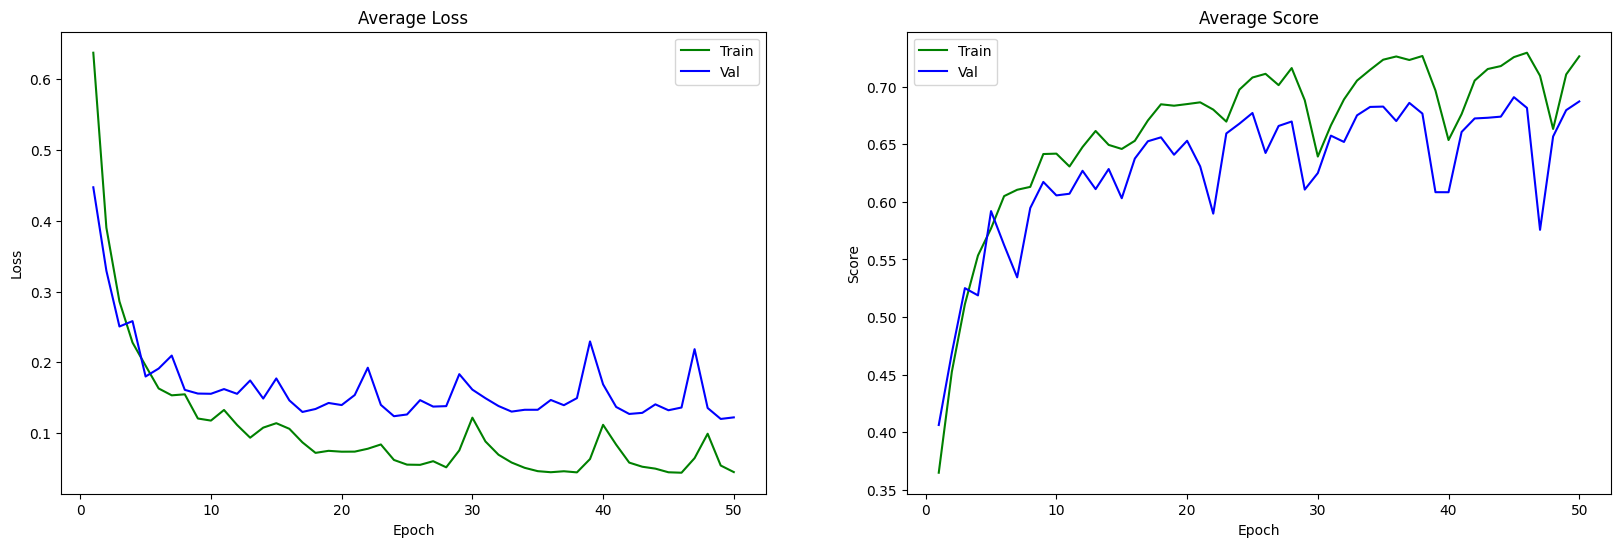

In [6]:
# plotting training results
training_and_testing.plot_training_results(results, plotsize=(20, 6))

In [21]:
# resetting model, optimizer, learning rate scheduler
final_model = CGNet.Context_Guided_Network(classes=n_classes)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=learning_rate)

# re-training model on entire training set and saving its weights
final_n_epochs = 25
training_and_testing.train_model(
    device, final_model, train_dataset, batch_size, final_n_epochs, score_fn, loss_fn, final_optimizer, verbose=True)
torch.save(final_model.state_dict(), weights_path + model_name + '.pth')

Device: cpu.
--- Epoch 1/25 ---
average_train_loss: 0.3885005747374629, average_train_score: 0.4703359305858612
--- Epoch 2/25 ---
average_train_loss: 0.1832139862131467, average_train_score: 0.5989704132080078
--- Epoch 3/25 ---
average_train_loss: 0.14947268212756915, average_train_score: 0.6299071907997131
--- Epoch 4/25 ---
average_train_loss: 0.12569248515936887, average_train_score: 0.6535412669181824
--- Epoch 5/25 ---
average_train_loss: 0.11870988374159298, average_train_score: 0.6624074578285217
--- Epoch 6/25 ---
average_train_loss: 0.1106127407199094, average_train_score: 0.6707322597503662
--- Epoch 7/25 ---
average_train_loss: 0.10657171905040741, average_train_score: 0.6749282479286194
--- Epoch 8/25 ---
average_train_loss: 0.10118339855354527, average_train_score: 0.6814890503883362
--- Epoch 9/25 ---
average_train_loss: 0.09887901670158702, average_train_score: 0.6841087341308594
--- Epoch 10/25 ---
average_train_loss: 0.09337277983640745, average_train_score: 0.691497

In [22]:
# loading pretrained final model
try:
    final_model
except:
    final_model = CGNet.Context_Guided_Network(classes=n_classes)
    final_model.load_state_dict(torch.load(weights_path + model_name + '.pth'))

# testing model on test dataset
test_score_fn = metrics.batch_IoU
label_names = list(segmentation_labels.labels.keys())
batch_IoU = training_and_testing.test_model(device, final_model, test_dataset, batch_size, test_score_fn)
batch_IoU_with_labels = { label: score for label, score in list(zip(label_names, batch_IoU.tolist())) }
batch_mIoU = batch_IoU.mean().item()
for label in batch_IoU_with_labels:
    print(f'batch_IoU_{label}: {batch_IoU_with_labels[label]}')
print(f'batch_mIoU={batch_mIoU}')

Device: cpu.

Inference completed in around 422 seconds.
batch_IoU_background: 0.9578250050544739
batch_IoU_lips: 0.5453455448150635
batch_IoU_eyes: 0.4153495728969574
batch_IoU_nose: 0.7390982508659363
batch_IoU_skin: 0.8666799068450928
batch_IoU_hair: 0.8248153924942017
batch_IoU_eyebrows: 0.40005558729171753
batch_IoU_ears: 0.6773653626441956
batch_IoU_teeth: 0.6901488900184631
batch_IoU_beard: 0.8689663410186768
batch_IoU_sunglasses: 0.9124451279640198
batch_mIoU=0.7180085778236389


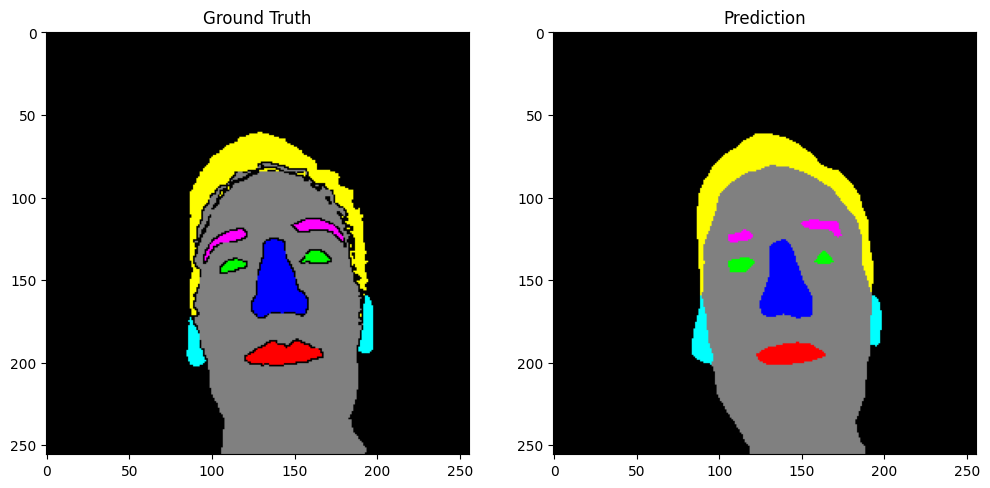

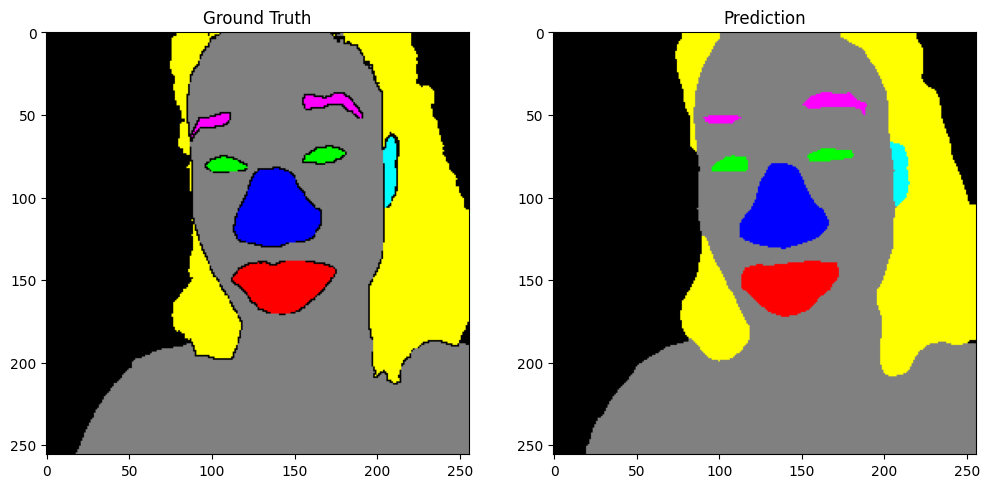

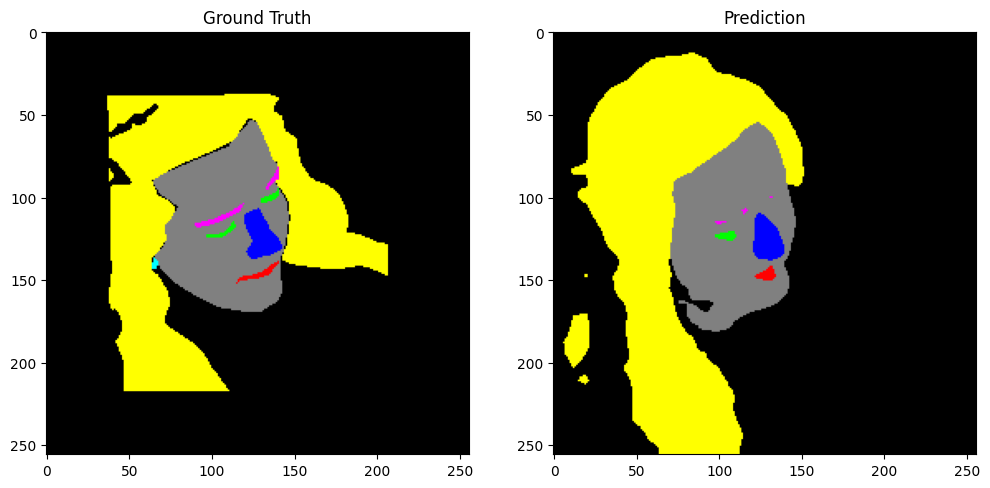

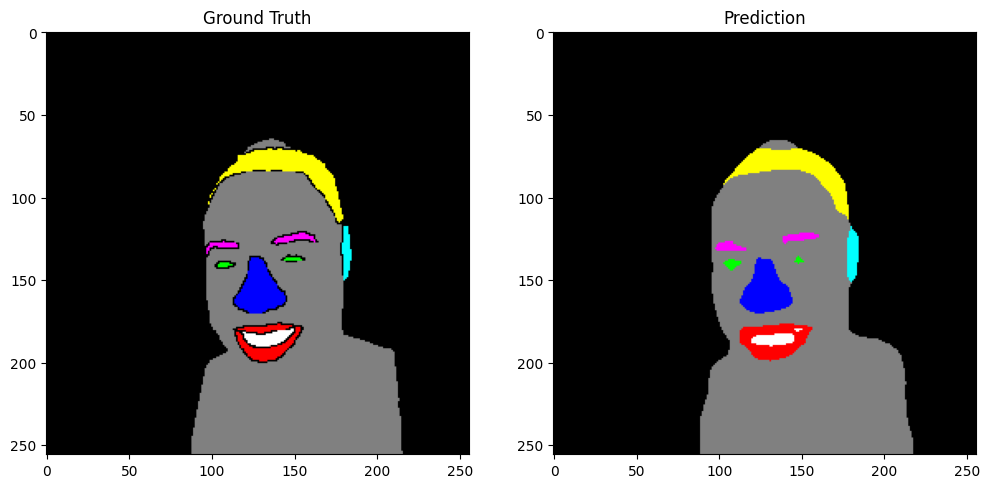

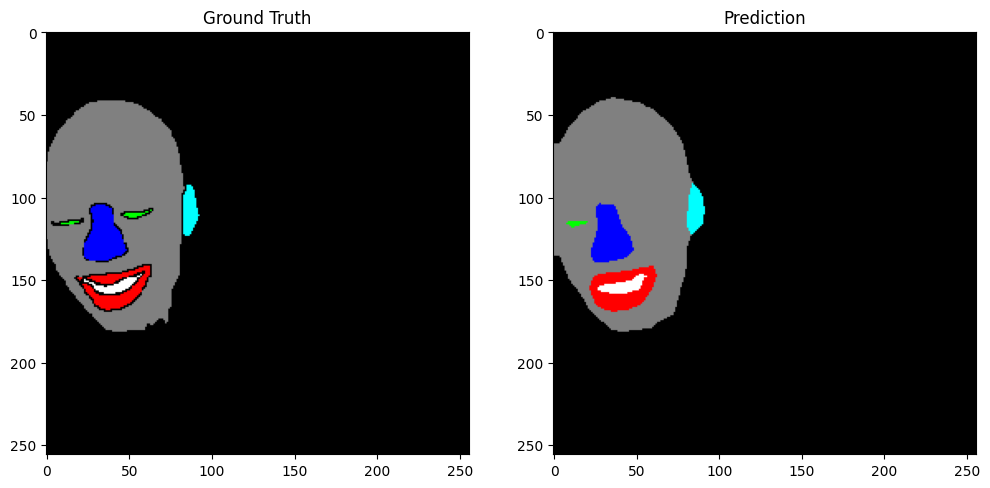

In [25]:
# plotting some random examples from test dataset
random_images = torch.zeros((n_examples, 3, tH, tW))
random_targets = torch.zeros((n_examples, n_classes, tH, tW))
for i in range(n_examples):
    random_idx = torch.randint(high=len(test_dataset), size=(1,))
    random_image, random_target = test_dataset[random_idx]
    random_images[i] = random_image
    random_targets[i] = random_target
with torch.no_grad():
    final_model.eval()
    random_output = final_model(random_images)[0]
channels_max, _ = torch.max(random_output, axis=1)
random_predictions = (random_output == channels_max.unsqueeze(axis=1))
for i in range(n_examples):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Ground Truth')
    plt.imshow(utils.from_DHW_to_HWD(color_processing.colorize_segmentation_masks(random_targets[i], segmentation_labels.labels)))
    plt.subplot(1, 2, 2)
    plt.title('Prediction')
    plt.imshow(utils.from_DHW_to_HWD(color_processing.colorize_segmentation_masks(random_predictions[i], segmentation_labels.labels)))